In [1]:
import matplotlib.pyplot as plt
from matplotlib.patches import Rectangle

import cartopy.crs as ccrs
import cartopy.feature as cfeature
from cartopy.io import shapereader

import numpy as np

import os
cwd = os.getcwd()

# Figure 1: Zebra

<IPython.core.display.Javascript object>


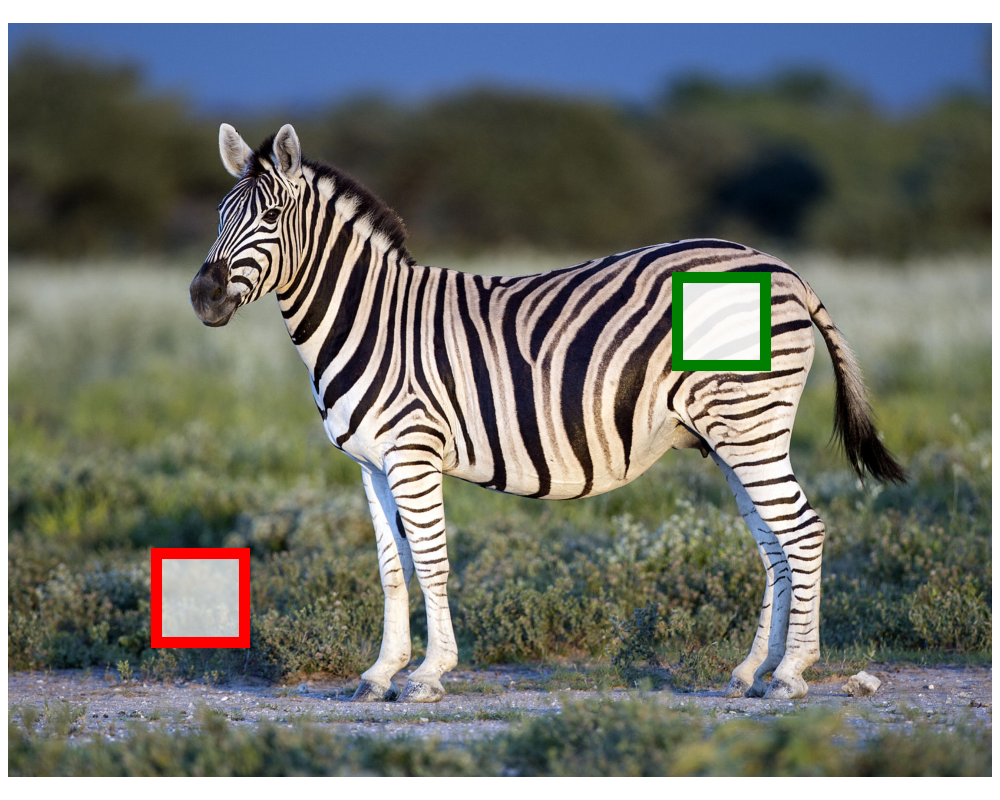

In [2]:
zebra = plt.imread("resources/zebra.jpg")

fig = plt.figure(figsize=(5, 4), constrained_layout=True, dpi=200)
ax = fig.add_subplot(111)

ax.imshow(zebra[:, 250:])

# Add J-invariant patch
ax.add_patch(Rectangle(xy=(1135, 430), width=150, height=150, fc="white", ec="g", lw=0, alpha=0.9))
ax.add_patch(Rectangle(xy=(1135, 430), width=150, height=150, fc="none", ec="g", lw=4, alpha=1.0))

# Add J-variant patch
ax.add_patch(Rectangle(xy=(250, 900), width=150, height=150, fc="white", ec="r", lw=0, alpha=0.7))
ax.add_patch(Rectangle(xy=(250, 900), width=150, height=150, fc="none", ec="r", lw=4, alpha=1.0))

ax.axis("off")

plt.savefig("figures/zebra.pdf")
plt.show()

# Figure 2: model architecture

<IPython.core.display.Javascript object>


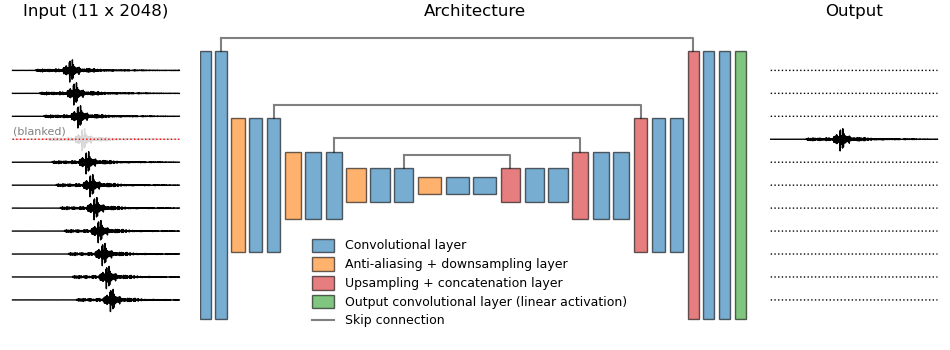

In [3]:
# Load the earthquake waveform
master = np.load("resources/master_waveforms_offset.npy")

# Plotting parameters
wv_offset = 30

c_conv = "C0"
c_down = "C1"
c_up = "C3"
c_out = "C2"

patch_args = {
    "ec": "k",
    "linewidth": 1.0,
    "alpha": 0.6,
}

skip_args = {
    "c": "gray",
    "ls": "-",
    "zorder": -1,
}

# Draw canvas
fig = plt.figure(figsize=(9.5, 3.5), constrained_layout=True)
gs = fig.add_gridspec(1, 5)

""" Input panel """

ax1 = fig.add_subplot(gs[0, 0])

for i, wv in enumerate(master):
    if i == 3:
        ax1.plot(wv - wv_offset*i, c="k", lw=1, alpha=0.15)
        ax1.plot(np.zeros_like(wv) - wv_offset*i, c="r", lw=1, ls=":")
        ax1.text(x=0, y=-wv_offset*i+6, s="(blanked)", fontsize=8, alpha=0.5)
    else:
        ax1.plot(wv - wv_offset*i, c="k", lw=1)
    
ax1.axis("off")
ax1.set_ylim((-12*wv_offset, 2*wv_offset))
ax1.set_title("Input (11 x 2048)", fontsize=12)



""" Architecture panel """

ax2 = fig.add_subplot(gs[0, 1:4])
ax2.axis("off")
ax2.set_title("Architecture")

# Patch (starting) parameters
patch_width = 0.02
patch_height = 1
skip_length = 0.05
x0 = 0
y0 = (1 - patch_height) / 2
dx = 0.008

# Buffer for skip connections
skip_locs = []


""" Encoder """

# Input layers
for i in range(2):
    ax2.add_patch(Rectangle(xy=(x0, y0), width=patch_width, height=patch_height, fc=c_conv, **patch_args))
    x0 += patch_width + dx

# 4 downsampling blocks
for i in range(4):
    
    # Add skip connection
    x_mid = x0 - 0.5*patch_width - dx
    y_top = y0 + patch_height
    ax2.plot([x_mid, x_mid], [y_top, y_top + skip_length], **skip_args)
    skip_locs.append((x_mid, y_top + skip_length))
    
    # Adjust patch size
    patch_width *= 1.2
    patch_height *= 0.5
    y0 = (1 - patch_height) / 2
    
    # Add downsampling layer
    ax2.add_patch(Rectangle(xy=(x0, y0), width=patch_width, height=patch_height, fc=c_down, **patch_args))
    x0 += patch_width + dx
    
    # Add convolutional layers
    for i in range(2):
        ax2.add_patch(Rectangle(xy=(x0, y0), width=patch_width, height=patch_height, fc=c_conv, **patch_args))
        x0 += patch_width + dx
         

""" Decoder """

# 4 upsampling blocks
for i in range(4):
    
    # Adjust patch size
    patch_width /= 1.2
    patch_height /= 0.5
    y0 = (1 - patch_height) / 2
    
    # Add upsampling layer
    ax2.add_patch(Rectangle(xy=(x0, y0), width=patch_width, height=patch_height, fc=c_up, **patch_args))
    x0 += patch_width + dx
    
    # Add skip connection
    x_mid = x0 - 0.5*patch_width - dx
    y_top = y0 + patch_height
    x_prev, y_prev = skip_locs[3-i]
    ax2.plot([x_mid, x_mid, x_prev], [y_top, y_top + skip_length, y_prev], **skip_args)
    
    # Add convolutional layers
    for i in range(2):
        ax2.add_patch(Rectangle(xy=(x0, y0), width=patch_width, height=patch_height, fc=c_conv, **patch_args))
        x0 += patch_width + dx
    
# Add output layer
ax2.add_patch(Rectangle(xy=(x0, y0), width=patch_width, height=patch_height, fc=c_out, **patch_args))
x0 += patch_width + dx

ax2.set_xlim((0, x0))
ax2.set_ylim((-0.1, 1.1))

""" Legend """

patch_width = 0.04
patch_height = 0.05
x0 = 0.2
y0 = 0.25
dy = 0.07
text_dx = patch_width + 0.02
text_dy = 0.01
font = 9

ax2.add_patch(Rectangle(xy=(x0, y0), width=patch_width, height=patch_height, fc=c_conv, **patch_args))
ax2.text(x=x0 + text_dx, y=y0 + text_dy, s="Convolutional layer", fontsize=font)

y0 -= dy
ax2.add_patch(Rectangle(xy=(x0, y0), width=patch_width, height=patch_height, fc=c_down, **patch_args))
ax2.text(x=x0 + text_dx, y=y0 + text_dy, s="Anti-aliasing + downsampling layer", fontsize=font)

y0 -= dy
ax2.add_patch(Rectangle(xy=(x0, y0), width=patch_width, height=patch_height, fc=c_up, **patch_args))
ax2.text(x=x0 + text_dx, y=y0 + text_dy, s="Upsampling + concatenation layer", fontsize=font)

y0 -= dy
ax2.add_patch(Rectangle(xy=(x0, y0), width=patch_width, height=patch_height, fc=c_out, **patch_args))
ax2.text(x=x0 + text_dx, y=y0 + text_dy, s="Output convolutional layer (linear activation)", fontsize=font)

y0 -= dy - patch_height / 2
ax2.plot([x0, x0 + patch_width], [y0, y0], **skip_args)
ax2.text(x=x0 + text_dx, y=y0 + text_dy - patch_height / 2, s="Skip connection", fontsize=font)



""" Output panel """

ax3 = fig.add_subplot(gs[0, 4])

for i, wv in enumerate(master):
    if i == 3:
        ax3.plot(wv - wv_offset*i, c="k", lw=1)
    else:
        ax3.plot(np.zeros_like(wv) - wv_offset*i, c="k", lw=1, ls=":")
        
ax3.axis("off")
ax3.set_ylim((-12*wv_offset, 2*wv_offset))
ax3.set_title("Output", fontsize=12)

plt.savefig("figures/architecture.pdf")
plt.show()

# Figure 3: DAS cable location

In [4]:
# Load high-resolution shapefile
land_shp = shapereader.Reader(os.path.join(cwd, "resources", "geography", "land", "land_polygons_clipped.shp"))

# Load cable coordinates
coords_file_HCMR = os.path.join(cwd, "resources", "cable_coordinates", "hcmr_coords.npy")
coords_file_nestor = os.path.join(cwd, "resources", "cable_coordinates", "nestor_coords.npy")

ch_offset = 20
ch_max_HCMR = 670
ch_max_Nestor = 900

coords_HCMR = np.load(coords_file_HCMR)
coords_HCMR = coords_HCMR[:, ch_offset:ch_max_HCMR]

coords_Nestor = np.load(coords_file_nestor)
coords_Nestor = coords_Nestor[:, ch_offset:ch_max_Nestor]

<IPython.core.display.Javascript object>


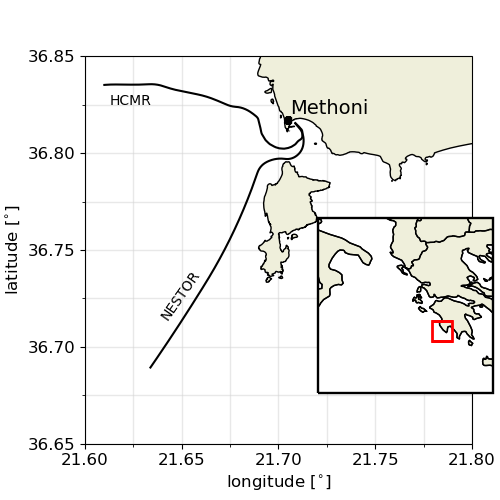

In [5]:
font = 12

lat_min = 36.65
lat_max = 36.85
lon_min = 21.60
lon_max = 21.80

# Define grid major/minor ticks
xlocs = np.linspace(lon_min, lon_max, 5)
ylocs = np.linspace(lat_min, lat_max, 5)

xlocs_minor = np.linspace(lon_min, lon_max, 9)
ylocs_minor = np.linspace(lat_min, lat_max, 9)

# Projection to be used
proj = ccrs.PlateCarree()

# Draw canvas
fig = plt.figure(figsize=(5, 5), constrained_layout=True)
ax = fig.add_subplot(111, projection=proj)

# Set axis limits
ax.set_xlim((lon_min, lon_max))
ax.set_ylim((lat_min, lat_max))

# Add coastline polygons
for record, geometry in zip(land_shp.records(), land_shp.geometries()):
    ax.add_geometries([geometry], proj, facecolor=cfeature.COLORS["land"], edgecolor="black")
    
# Add Methoni location
ax.plot(21.705, 36.817, "ks", ms=5)
ax.text(21.706, 36.820, "Methoni", fontsize=14)

# Plot HCMR cable coordinates
ax.plot(coords_HCMR[1], coords_HCMR[0], c="k", zorder=999)
ax.text(x=21.613, y=36.825, s="HCMR", fontsize=10)

# Plot NESTOR cable coordinates
ax.plot(coords_Nestor[1], coords_Nestor[0], c="k", zorder=999)
ax.text(x=21.638, y=36.714, s="NESTOR", fontsize=10, rotation=55)

# Add axis ticks/labels
ax.set_xticks(xlocs)
ax.set_yticks(ylocs)
ax.set_xticklabels(labels=["%.2f" % x for x in xlocs], fontsize=font)
ax.set_yticklabels(labels=["%.2f" % y for y in ylocs], fontsize=font)
ax.set_xticks(xlocs_minor, minor=True)
ax.set_yticks(ylocs_minor, minor=True)

for x in xlocs_minor:
    ax.axvline(x, ls="-", c="lightgray", lw=1, alpha=0.5, zorder=-1)
for y in ylocs_minor:
    ax.axhline(y, ls="-", c="lightgray", lw=1, alpha=0.5, zorder=-1)

ax.set_xlabel(r"longitude [$^{\circ}$]", fontsize=font)
ax.set_ylabel(r"latitude [$^{\circ}$]", fontsize=font)


# Inset panel (regional view)
left, bottom, width, height = 0.635, 0.215, 0.35, 0.35
ax2 = fig.add_axes([left, bottom, width, height], projection=proj)
ax2.set_yticks([])
ax2.set_xticks([])

ax2.set_xlim((16, 24))
ax2.set_ylim((34, 42))

# Add zoom box
ax2.plot(21.705, 36.817, "s", ms=15, c="none", mew=2, mec="r")

# Add low-resolution land and countries
resolution = "50m"
ax2.add_feature(cfeature.NaturalEarthFeature('physical', 'land', resolution, edgecolor='black', facecolor=cfeature.COLORS['land']))
ax2.add_feature(cfeature.NaturalEarthFeature('cultural', 'admin_0_countries', resolution, edgecolor='black', facecolor='none'))
ax2.spines["geo"].set_linewidth(1.7)

plt.savefig("figures/cable_map.pdf")
plt.show()